In [3]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Activation, LSTM
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard

import pickle
import heapq


# Text generation with LSTM

Let's create a logs directory for TensorBoard:

In [5]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)


We are setting up TensorBoard to monitor our model's training process. First, we create a directory named logs with a timestamp to keep track of different training runs. Then, we define a TensorBoard callback that will log key training metrics, including histograms and the model's computation graph.

## Load and preprocess the text dataset


In [7]:
# Load the dataset
path = 'data/1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

# Tokenize the text
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

# Create a dictionary of unique words
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))


corpus length: 581423


We are loading a text dataset, processing it into individual words, and creating a dictionary to map each unique word to an index. This prepares the text for further analysis or machine learning tasks.

In [8]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])

# Create feature and label sets
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1


We are preparing data for training a machine learning model by creating input sequences of words and their corresponding next word. This transforms raw text into a structured numerical format for model training.

In [9]:
# Define the model
model = Sequential()
model.add(Input(shape=(WORD_LENGTH, len(unique_words))))  # Explicit Input layer
model.add(LSTM(64))  # No need to specify input_shape again
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))


We are defining a neural network model using an LSTM (Long Short-Term Memory) layer to predict the next word in a sequence. The model takes a sequence of words as input and outputs a probability distribution over all possible next words.

Let's configure the optimizer and compiling the model for training:

In [10]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=64, epochs=20, shuffle=True, callbacks=[tensorboard_callback]).history


Epoch 1/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 96s 56ms/step - accuracy: 0.0632 - loss: 6.5518 - val_accuracy: 0.0893 - val_loss: 6.7528
Epoch 2/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 87s 53ms/step - accuracy: 0.1152 - loss: 5.8995 - val_accuracy: 0.1008 - val_loss: 6.6607
Epoch 3/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 88s 54ms/step - accuracy: 0.1329 - loss: 5.6516 - val_accuracy: 0.1070 - val_loss: 6.5894
Epoch 4/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.1509 - loss: 5.4582 - val_accuracy: 0.1039 - val_loss: 6.6380
Epoch 5/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 87s 54ms/step - accuracy: 0.1667 - loss: 5.2897 - val_accuracy: 0.1135 - val_loss: 6.5904
Epoch 6/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 86s 53ms/step - accuracy: 0.1881 - loss: 5.1107 - val_accuracy: 0.0999 - val_loss: 6.6729
Epoch 7/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 85s 52ms/step - accuracy: 0.2094 - loss: 4.9253 - val_accuracy: 0.1014 - val_loss: 6.8531
Epoch 8/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 85s 53ms/step - accuracy: 0.2307 -

### Training Results

After 20 epochs, we can observe the following trends:

- **Training Accuracy**: The model's accuracy gradually increased from 6.32% in the first epoch to 41.59% by the 20th epoch, indicating that it's learning from the training data.
- **Training Loss**: The training loss decreased steadily from 6.55 to 3.63, suggesting the model is improving its understanding of the data over time.
  
However, when we look at the **Validation Results**:
- **Validation Accuracy**: It remained quite low, fluctuating between 7% and 10%. This indicates that the model isn't generalizing well to unseen data.
- **Validation Loss**: The validation loss started to rise after a few epochs, which is a sign that the model might be overfitting to the training data (i.e., performing worse on the validation set as it becomes more specialized in the training data).

### Takeaways
- The model is improving in terms of training accuracy, but it struggles to perform well on new, unseen data (validation set).
- To improve the model's generalization:
  1. Consider **lowering the learning rate** to avoid overshooting optimal solutions.
  2. Experiment with modifying the **model architecture**, such as adding more layers or units, or incorporating regularization techniques like dropout.
  3. If the dataset is small or imbalanced, apply **data augmentation** to help the model generalize better.

In conclusion, while the model is making progress, it needs further adjustments to improve its performance on unseen data.


### Save the model and the training history (such as accuracy and loss over epochs):

In [ ]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))


### Training and Validation Performance Plots

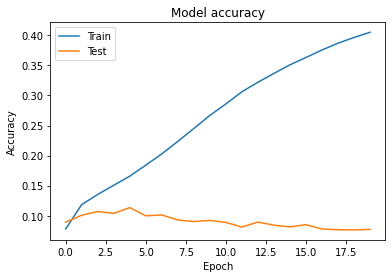

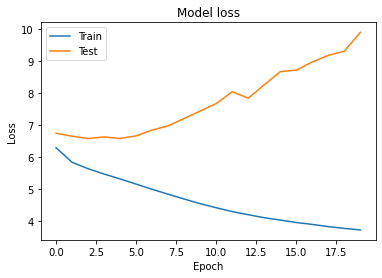

In [11]:
# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Both plots help in evaluating the model's learning progress and its ability to generalize to unseen data (validation set). The accuracy plot shows how well the model is performing, and the loss plot reveals how the model is minimizing error.


Let's processes a given text for model input like removing any punctuation marks from the input text and creates a one-hot encoded representation:

In [13]:
import string

def prepare_input(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        if word in unique_word_index:  # Check if word exists in dictionary
            x[0, t, unique_word_index[word]] = 1
    return x


## Text Prediction

In [14]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        x[0, t, unique_word_index[word]] = 1
    return x

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_word = unique_words[next_index]
        text = text.split()[1:]
        text.append(next_word)
        text = ' '.join(text)
        completion += ' ' + next_word
        if len(completion.split()) > WORD_LENGTH:
            break
    return completion

quotes = [
    "It is not a lack of love, but a lack of",
    "That which does not kill us makes us",
    "I'm not upset that you lied to me, I'm",
    "And those who were seen dancing were",
    "It is hard enough to remember my opinions, without also remembering my"
]

for q in quotes:
    seq = q.lower().split()
    print(q)
    print(predict_completion(' '.join(seq[-WORD_LENGTH:])))
    print()


It is not a lack of love, but a lack of
 course it is the most important

That which does not kill us makes us
 in the same place and the

I'm not upset that you lied to me, I'm
 said he when i came out

And those who were seen dancing were
 a little time to go for

It is hard enough to remember my opinions, without also remembering my
 own and so there was a



This **sample** function processes the model's probability distribution by applying logarithm and normalization, then selects the top n most likely words.

The **predict_completion** function takes an input text, converts it into a numerical format, and feeds it into the model.
It predicts the next word iteratively, updating the text each time.
The process continues until the generated completion reaches a predefined word length.